## Train a neural network to learn and predict spiral dataset class. Moreover like classification model.

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, TensorDataset, DataLoader

In [9]:
seed = 123
dtype = torch.float32
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
torch.set_default_device(device)
torch.manual_seed(seed)
generator = torch.Generator(device=device).manual_seed(seed)

In [10]:
def generate_spiral_data(points_per_class=100, num_classes=3, noise=0.2):
    X = np.zeros((points_per_class * num_classes, 2))  
    y = np.zeros(points_per_class * num_classes, dtype='uint8') 

    for j in range(num_classes):
        ix = range(points_per_class * j, points_per_class * (j + 1))
        r = np.linspace(0.0, 1, points_per_class)  # radius
        t = np.linspace(j * 4, (j + 1) * 4, points_per_class) + np.random.randn(points_per_class) * noise
        X[ix] = np.c_[r * np.sin(t * 2.5), r * np.cos(t * 2.5)]
        y[ix] = j

    return X, y

X_dataset, y_dataset = generate_spiral_data(points_per_class=500, num_classes=3, noise=0.05)
X_dataset = torch.tensor(X_dataset, dtype=torch.float32).to(device)
y_dataset = torch.tensor(y_dataset).to(device)

dataset = TensorDataset(X_dataset, y_dataset)
total_size = len(dataset)

train_size = int(total_size * 0.6)
val_size = int(total_size * 0.2)
test_size = int(total_size * 0.2)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, generator=generator)  

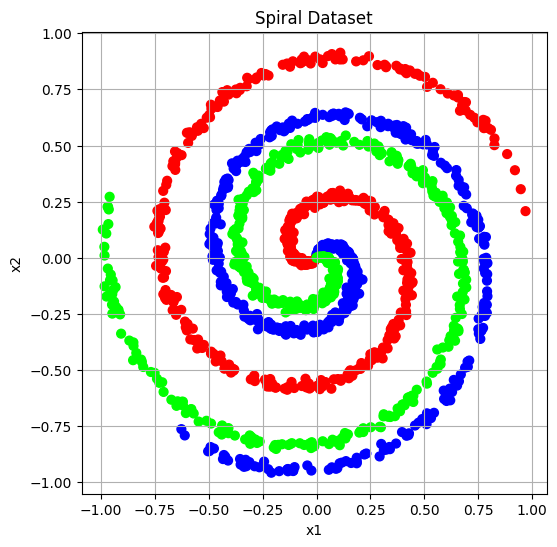

In [11]:
def plot_classification_data(X, y):
    plt.figure(figsize=(6,6))
    plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], c=y.cpu(), cmap="brg", s=40)
    plt.title("Spiral Dataset")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.show()

plot_classification_data(X_dataset, y_dataset)

In [12]:
class SpiralModel(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(SpiralModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_size)
        )

    def forward(self, input):
        return self.layers(input)

In [13]:
epoch = 200
print_per_epoch = 10

def accuracy(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for _, data in enumerate(test_loader):
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

def eval(model, loss_fn, val_loader):
    running_loss = 0
    model.eval()

    with torch.no_grad():
        for _, data in enumerate(val_loader):
            inputs, labels = data

            y_pred = model(inputs)

            loss = loss_fn(y_pred, labels)
            running_loss += loss.item()
    return running_loss / len(val_loader)


def train(model, loss_fn, optimizer, train_loader, val_loader):
    model.train()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    for i in range(epoch):
        running_loss = 0
        for _, data in enumerate(train_loader):
            inputs, labels = data

            optimizer.zero_grad()

            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            running_loss += loss.item()

            loss.backward()

            optimizer.step()
        train_loss_avg = running_loss / len(train_loader)
        val_loss_avg = eval(model, loss_fn, val_loader)
        scheduler.step(val_loss_avg)
        
        if (i+1)%print_per_epoch == 0:
            print('LOSS train {} valid {}'.format(train_loss_avg, val_loss_avg))

In [14]:
input_size = 2
output_size = 3
learning_rate = 1e-3

model = SpiralModel(input_size, output_size)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

train(model, criterion, optimizer, train_loader, val_loader)
acc = accuracy(model, test_loader)

print('ACC {}'.format(acc))

LOSS train 0.9827747879357174 valid 0.9433881580829621
LOSS train 0.7644639117964382 valid 0.762528246641159
LOSS train 0.55237765764368 valid 0.5528827339410782
LOSS train 0.41504645810045043 valid 0.43132043182849883
LOSS train 0.33182231311140387 valid 0.343091744184494
LOSS train 0.2474341438762073 valid 0.2586996093392372
LOSS train 0.20639792444377109 valid 0.22128608971834182
LOSS train 0.16326988591202374 valid 0.16995938643813133
LOSS train 0.1285136798075561 valid 0.13106274977326393
LOSS train 0.10769029713139452 valid 0.10038072429597378
LOSS train 0.09515913588733509 valid 0.09021645598113537
LOSS train 0.075883522693967 valid 0.08245673142373562
LOSS train 0.06427623421467583 valid 0.05845002569258213
LOSS train 0.06143988903354982 valid 0.0508651752024889
LOSS train 0.05689242482185364 valid 0.04694375246763229
LOSS train 0.04808570174821492 valid 0.043629987817257646
LOSS train 0.04407580023438766 valid 0.03799022659659386
LOSS train 0.04559972140424211 valid 0.03748475